# EEB729- Breeding Microbial Communities 3

Ok so this is a corrected notebook, similar to last week. Unlike in previous weeks you will only need to run this once to get all the data required for analysis.

I'll assign each of you a number so that you each consider a different regional species pool. Please make sure to set this in the notebook below (in the custom paramater section). 


Maddie Bender: 1
Richard Li :2
Madeleine Mankowski :3

# Load Packages

In [7]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
import pandas as pd
colors = sns.color_palette()
%matplotlib inline

# Default Functions

This chunk contains a set of functions and objects that you will need to perform community level selection. We are putting them all together so you can load them once and then they will be available in all subsequent chunks.  You will (hopefully) never need to change any of these functions/objects. 

In [8]:
#Make dynanmics by default we will use the Microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Create a regional species pool
def RegionalSpeciesPool(assumptions):
    # Parameters
    S_tot = int(np.sum(assumptions['SA'])+assumptions['Sgen']) # Total number of species (specialist + generalist)
    F = len(assumptions['SA']) # Number of consumer families
    consumer_names = ['S'+str(k) for k in range(S_tot)]
    family_names = ['F'+str(k) for k in range(F)]
    well_names = ['W'+str(k) for k in range(assumptions['n_wells'])]
    consumer_index = [[family_names[m] for m in range(F) for k in range(assumptions['SA'][m])]
    +['GEN' for k in range(assumptions['Sgen'])],consumer_names]
    
    # Assign drawn values based on power-law distribution
    # Creating an array with M rows an n_wells columns with 0 entries
    pool = np.random.power(1, size  = S_tot) 
    return pool/np.sum(pool)  # Relative species abundance in regional pool

# Sample each communities from a different regional species pool
def SampleFromPools(plate_N, scale=10**6, inocula=10**6,Pool_Size = 100):
    S_tot = int(np.sum(assumptions['SA'])+assumptions['Sgen']) # Total number of species (specialist + generalist)
    N0 = np.zeros((plate_N.shape))
    consumer_index = plate_N.index
    well_names = plate_N.columns
    PA_vector = np.concatenate((np.repeat(0,S_tot - Pool_Size),np.repeat(1,Pool_Size)))
    np.random.shuffle(PA_vector)
    for k in range(plate_N.shape[1]):
        pool = np.random.power(1, size  = S_tot) * PA_vector
        pool = pool/np.sum(pool)
        consumer_list = np.random.choice(len(pool), size=inocula, replace=True, p=pool)
        my_tab = pd.crosstab(index=consumer_list, columns="count") # Calculate the cell count
        N0[my_tab.index.values,k] = np.ravel(my_tab.values / scale) # Scale to biomass

    # Make data.frame
    N0 = pd.DataFrame(N0,index=consumer_index,columns=well_names)
    return N0

# Compute the distances from the target resource 
def resource_distance_community_function(plate,R_target,sigma = 0.01): #Sigma is the measurement error
   R_tot = plate.R.shape[0]
   well_tot = plate.R.shape[1]
   R_dist = np.sqrt(np.sum(np.array((np.tile(R_target,(well_tot,1)) - plate.R.T)**2)[:,1:],axis=1))
   return (np.array(R_dist.T)* -1) * (1+ np.random.normal(0,sigma,well_tot))#(so we select for positive community function)

# Migrate from species pool to the plate 
def migrate_from_pool(plate, migration_factor,Pool_Size = 1000):
    # Migration plate
    migration_plate = SampleFromPools(plate.N,inocula = migration_factor,Pool_Size = Pool_Size)
    
    # Migration
    plate_migrated = plate.N + migration_plate 

    return plate_migrated


# Plot community function as a function of time    
def plot_community_function(function_df):
    import matplotlib.pyplot as plt
    #function_df
    time = range(0, len(function_df))
    plt.plot(time,function_df,'ko', markersize=2)
    ax = plt.gca()
    ax.set_xlabel("transfer")
    ax.set_ylabel("Community function")
    plt.show()



# Default Paramaters

To start with we will initalize the paramaters for the system. This section contains the default paramaters
for the simulations. I do not expect you guys to changes these. 

In [9]:
###### Default Paramater values taken from the package

sampling:'Binary' #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
SA: 120*np.ones(3) #Number of species in each familyMA': 30*np.ones(3), 
#Number of resources of each type
Sgen: 60 #Number of generalist species
muc: 10 #Mean sum of consumption rates
sigc: 3 #Standard deviation of sum of consumption rates for Gaussian and Gamma models
q: 0.0 #Preference strength (0 for generalist and 1 for specialist)
c0:0.0 #Sum of background consumption rates in binary model
c1:1. #Specific consumption rate in binary model
l:0.8 #Leakage fraction
fs:0.45 #Fraction of secretion flux with same resource type
fw:0.45 #Fraction of secretion flux to 'waste' resource
sparsity:0.2 #Effective sparsity of metabolic matrix
n_wells:10 #Number of independent wells
S:100 #Number of species per well
food:0 #index of food source
R0_food:1000 #unperturbed fixed point for supplied food
regulation:'independent' #mhttp://localhost:8888/notebooks/EEB279_Exercise_3.ipynb#etabolic regulation (see dRdt)
response:'type I' #functional response (see dRdt)
supply:'off' #resource supply (see dRdt)
    

### Paramaters that we will overwrite ###
S=100
n_wells = 24
m = 0 #mortality
c1 = 0.01 #Rescale uptake rate part 1. This is needed to avoid numerical errors that slow down the simulations
muc = 0.1 # Rescale uptake part 2
scale = 10**9  #scale is a conversion factor specifying the number of individual microbial cells present when N = 1.
#Set to 10**6 to avoid numerical errors 




### Initialize state of the system ###

# set up default paramater values
assumptions = a_default.copy()
assumptions.update({'n_wells' : n_wells,
                    'm' : m,
                   'c1' :c1,
                   'muc' :muc})

# Custom paramaters

So now lets define the paramaters that we will be manipulating. For this exercise, you should only have to manipulate the pool_id

In [19]:
#Paramaters that are specific to the simulations we are running. 
ng_pre = 20 #Number of transfers
ng_post = 20
t = 48 #Transfer time (hrs)
d_fac  = 1/1000 # Dilution factor(i.e what fraction of the community do we transfer.) at every passage
n_inoc =10**4  #Number of cells sampled from the regional species at start
# To do replicates just repeat the simulation with a different pool_id
pool_id = 100 # The unique ID for each student, changing this ensures that each of you will perform simulations using 
# a different species pool. 


# Generate Target Resource distribution

This bit of code is used to generate a distribution of resources from which the target resource distribution will be sampled. For this we are going to assume a large inoculum size so we can get a rough idea of what diverse communities should generate.

In [20]:
np.random.seed(0) # Global random seed (i.e all participants)
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
# Make plate
target_plate = Community(init_state,dynamics,params,parallel=False) # If using mac set parallel to true this speed up your simulations
np.random.seed(0) # Global random seed (i.e all participants)
target_plate.N = SampleFromPools(target_plate.N,inocula=n_inoc,Pool_Size = S) # Populate the well by sampling from a different species pool S_size determines the number of species in each sub-poool
function_df = list() #list of the functions of each community!
for i in range(0, ng_pre):
    target_plate.Propagate(t)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    target_plate.Passage(TM)
target_plate.Propagate(t)
Target_distribution = np.array(target_plate.R.T)[:,1:].flatten()
R_tot = target_plate.R.shape[0]
well_tot = target_plate.R.shape[1]
R_target = np.concatenate([np.zeros(1),np.random.choice(Target_distribution,R_tot-1)])

# Before Reproduction

Set up plate that has some initial variability in function at equilibrium

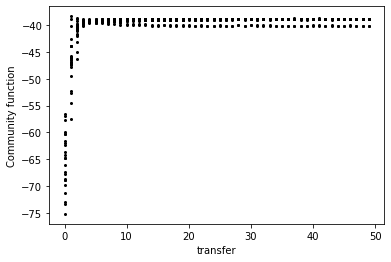

In [21]:
# Set up
np.random.seed(0) # Global random seed (i.e all participants)
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
# Make plate
ctrl_plate = Community(init_state,dynamics,params,parallel=True) # If using mac set parallel to true this speed up your simulations
np.random.seed(pool_id) # Global random seed (i.e all participants)
ctrl_plate.N = SampleFromPools(ctrl_plate.N,inocula=n_inoc,Pool_Size = S) # Populate the well by sampling from a different species pool S_size determines the number of species in each sub-poool
pre = list() #list of the functions of each community!
for i in range(0,50):
    ctrl_plate.Propagate(t)
    community_function = resource_distance_community_function(ctrl_plate, R_target = R_target,sigma=0.001)
    pre.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    ctrl_plate.Passage(TM)
ctrl_plate.Propagate(t)
plot_community_function(pre)


# Reproduction

Ok we are going to passage the communities that you have equilibrated using different bottlenecks and migrating different number of cells. We will repeat this using many different bottlenecks and migration size. This will take a long time to run. 

In [ ]:
passage_plate  = ctrl_plate.copy()


In [ ]:

b_ext = 1
m_ext  = 0
rs = 0
passage_plate = ctrl_plate.copy()
np.random.seed(rs)
#passage_plate.N = np.rint(passage_plate.N*scale)/scale 
#This hack discretises the population before passaging which allows me to calculate the  
# precise fraction to transfer. The actual multinomial samplying is handled by the passage function
TM = np.eye(n_wells) * b_ext/(np.sum(passage_plate.N.values,axis = 0) * scale) 
#TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
passage_plate.Passage(TM)
passage_plate.N = np.rint(passage_plate.N*scale)/scale # redistcretise passaged cells.
#if m_ext >0:
#    passage_plate.N = migrate_from_pool(passage_plate, m_ext,Pool_Size = S)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    passage_plate.Propagate(t)
    community_function = resource_distance_community_function(passage_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    passage_plate.Passage(TM)
plot_community_function(post)

In [ ]:
save_df = pd.DataFrame()
for rs in range(0,1):
    for m_ext in [0,1,10,100,1000,10000]:
        for b_ext in [1,10,100,1000,10000]:
            passage_plate = ctrl_plate.copy()
            np.random.seed(rs)
            passage_plate.N = np.rint(passage_plate.N*scale)/scale 
            #This hack discretises the population before passaging which allows me to calculate the  
            # precise fraction to transfer. The actual multinomial samplying is handled by the passage function
            TM = np.eye(n_wells) * b_ext/(np.sum(passage_plate.N.values,axis = 0) * scale) 
            #Generate a transfer matrix that corresponds to transfering b_ext cells
            passage_plate.Passage(TM)
            passage_plate.N = np.rint(passage_plate.N*scale)/scale # redistcretise passaged cells.
            if m_ext >0:
                passage_plate.N = migrate_from_pool(passage_plate, m_ext,Pool_Size = S)
            #Ok now bring back to equilibrium recording function
            post = list()
            for i in range(0,ng_post):
                passage_plate.Propagate(t)
                community_function = resource_distance_community_function(passage_plate, R_target = R_target,sigma=0.01)
                post.append(community_function)
                TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
                passage_plate.Passage(TM)
            passage_plate.Propagate(t)
            full = pd.DataFrame(pre+post)
            full['Timepoint'] = full.index
            full = pd.melt(full,id_vars=['Timepoint'], var_name = 'Community_ID',value_name = 'Measured_Function')
            full['Pool_Random_Seed']  = pool_id
            full['Bottleneck_Size']  = b_ext
            full['Migration_Size'] = m_ext
            full['Replicate']  = rs            
            save_df = save_df.append(full)

In [ ]:
save_df.to_csv('Data/Migration_Bottleneck'  + str(pool_id) + '_' + str(n_inoc) + '.csv')